## Setup and Imports

Importing required libraries and dependencies.

In [1]:
# ensures that matplotlib plots are disdplayed inside the notebook 
%matplotlib inline

# provides access to system-specific parameters and functions
import sys
# helps with file and directory operations, enviornment variables, and process control
import os
# for image loading, processing, and manipulation
import cv2
import shutil

import matplotlib # for plotting and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import axes3d # for creating 3D plots
from tqdm import tqdm # library used for displaying progress bars for loops
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
)

import pathlib
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random 
print("Version information")

print("python: {}".format(sys.version))
print("matplotlib: {}".format(matplotlib.__version__))
print("numpy: {}".format(np.__version__))
print("tensorflow: {}".format(tf.__version__))
print("current working directory:", os.getcwd()) # prints curr working directory
print("list of files:", os.listdir())  # Lists the files in the current directory
print("cv2 version:", cv2.__version__)
print("tensorflow: {}".format(tf.__version__))

# Load image
import imageio

# automatically reloads modules before executing code
%load_ext autoreload
%autoreload 2

Version information
python: 3.12.1 (v3.12.1:2305ca5144, Dec  7 2023, 17:23:38) [Clang 13.0.0 (clang-1300.0.29.30)]
matplotlib: 3.9.2
numpy: 1.26.4
tensorflow: 2.17.0
current working directory: /Users/erin/Library/Mobile Documents/com~apple~CloudDocs/1_gt/2_gatechJunior/Fall24/CS4641/Alzheimer-Detection/notebooks
list of files: ['2_Model_2.ipynb', '1_CNN.ipynb', 'data_split', 'preprocessing.py', '3_Model_3.ipynb']
cv2 version: 4.10.0
tensorflow: 2.17.0


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15450985876227717001
xla_global_id: -1
]


## Dataset Parameters and Classes

In [3]:
DATASET_PATH = "../Data/"
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.3
IMAGE_SIZE = (248, 496)
data_dir = pathlib.Path(DATASET_PATH)
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]


# Corrupt Image Detection

In [4]:
from PIL import Image
import os

for root, _, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(('jpg', 'jpeg', 'png')):
            try:
                img = Image.open(os.path.join(root, file))
                img.load()  # Load image to detect issues
            except Exception as e:
                print(f"Corrupted image detected: {os.path.join(root, file)} - {e}")

## Dataset Directory Setup and Splitting

In [5]:
# print dataset directory path to confirm it's correct / exist
print(data_dir)
print(data_dir.exists())

# load and split dataset 
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
        labels="inferred",
        directory=data_dir,
        batch_size=BATCH_SIZE,
        validation_split=VALIDATION_SPLIT,
        seed=0,
        image_size=IMAGE_SIZE,
        subset='both',
        color_mode="grayscale")
test_ds = val_ds.shard(num_shards=3, index=0).concatenate(
               val_ds.shard(num_shards=3, index=1))
val_ds = val_ds.shard(num_shards=3, index=2)

# shuffle each dataset to improve training quality
train_ds = train_ds.shuffle(buffer_size=1000)
test_ds = test_ds.shuffle(buffer_size=1000)
val_ds = val_ds.shuffle(buffer_size=1000)

# print confirmation that data has been split 
# Final Split: 80% Training, 10% Testing, 10% Validation
print("data has been split")

../Data
True
Found 86437 files belonging to 4 classes.
Using 60506 files for training.
Using 25931 files for validation.
data has been split


## Sample Dataset Image Viauzliation

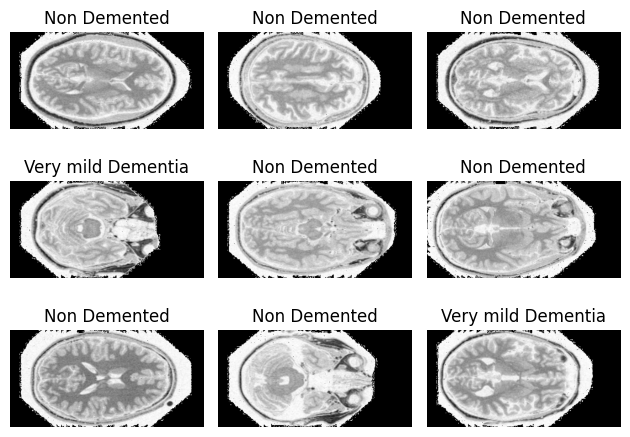

In [6]:
def image_sample_visualization(dataset):
    # map numeric labels to class names using predefined list
    label_to_classname = dict(zip(range(4), classes))
    dataset = dataset.shuffle(buffer_size=1000)
    iterator = dataset.as_numpy_iterator()
    # get a batch of 9 images and labels for visualization
    images = [iterator.next() for _ in range(9)]
    for i in range(9):
        plt.subplot(3, 3, i + 1)

        # extract images na dlabels from each batch
        imgs, labels = images[i]

        # randomly select an image from the batch
        index = random.randint(0, len(imgs) - 1)
        img = imgs[index]
        label = labels[index]

        # scale the iamge back to pixel values and convert to uint8 format
        img = (img * 255).astype(np.uint8)

        # show image
        plt.imshow(img, cmap='gray')
        plt.axis("off")
        plt.title(label_to_classname[label])

    plt.tight_layout()
    plt.show()
image_sample_visualization(test_ds)

## Model Definition and Training

In [7]:
num_classes = len(classes)

# initiate sequential CNN model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(*IMAGE_SIZE, 1)),

  # first convolutional block
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(), # max pooling layer to reduce spatial dimensions

  # second convolutional block
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # third convolutional block
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # dropout layer to prevent overfitting
  layers.Dropout(0.2),

  # flatten and fully connect layers
  layers.Flatten(),
  layers.Dense(128, activation='relu'),

  # output layer with number of units equal to the number of classes
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# display the model architecture
model.summary()

# number of epochs for training
epochs=10

# train the model using the training and validation dataset
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
print(history)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 248, 496, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 248, 496, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 124, 248, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 248, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 124, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 124, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    15,745,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,768,964 (60.15 MB)

 Trainable params: 15,768,964 (60.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 1209s 635ms/step - accuracy: 0.8613 - loss: 0.3955 - val_accuracy: 0.9905 - val_loss: 0.0250
Epoch 2/10
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 1014s 532ms/step - accuracy: 0.9917 - loss: 0.0245 - val_accuracy: 0.9970 - val_loss: 0.0099
Epoch 3/10
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 2367s 1s/step - accuracy: 0.9963 - loss: 0.0109 - val_accuracy: 0.9970 - val_loss: 0.0080
Epoch 4/10
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 1042s 548ms/step - accuracy: 0.9966 - loss: 0.0092 - val_accuracy: 0.9988 - val_loss: 0.0037
Epoch 5/10
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 993s 521ms/step - accuracy: 0.9982 - loss: 0.0064 - val_accuracy: 0.9995 - val_loss: 8.7846e-04
Epoch 6/10
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 1108s 581ms/step - accuracy: 0.9990 - loss: 0.0035 - val_accuracy: 0.9997 - val_loss: 0.0010
Epoch 7/10


2024-11-10 21:40:06.443316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 905 of 1000
2024-11-10 21:40:08.457285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1891/1891 ━━━━━━━━━━━━━━━━━━━━ 1067s 557ms/step - accuracy: 0.9976 - loss: 0.0078 - val_accuracy: 0.9990 - val_loss: 0.0022
Epoch 8/10
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 1060s 557ms/step - accuracy: 0.9993 - loss: 0.0021 - val_accuracy: 0.9999 - val_loss: 9.5022e-04
Epoch 9/10
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 1108s 582ms/step - accuracy: 0.9987 - loss: 0.0038 - val_accuracy: 0.9987 - val_loss: 0.0047
Epoch 10/10
1891/1891 ━━━━━━━━━━━━━━━━━━━━ 937s 492ms/step - accuracy: 0.9988 - loss: 0.0039 - val_accuracy: 0.9991 - val_loss: 0.0015


## Model Evaluation on Test Data

In [8]:
results = model.evaluate(test_ds)

541/541 ━━━━━━━━━━━━━━━━━━━━ 76s 127ms/step - accuracy: 0.9997 - loss: 8.8256e-04


## Single Batch Prediction and Accuracy Calculation

In [9]:
# prediction on a signle batch from test dataset
for images, labels in test_ds.take(1):
    # get predictions for batch
    prediction = model.predict_on_batch(images)
    # convert to label indices by taking class with the highest probability
    predicted_labels = np.argmax(prediction, axis=1)
    
    correct = 0 # count of correct predictions
    num = 0 # total number of predictiosn in the batch
    
    # compare predicted with actual
    for predicted, actual in zip(predicted_labels, labels):
        num += 1
        if predicted == actual:
            correct += 1
    
    # print accuracy for this batch
    print(correct/num)
    
    

1.0


2024-11-10 22:56:30.972931: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Save Trained Model

In [10]:
model.save('cnn.keras')

# Visualization
## Training and Validation Accuracy and Loss Visualization

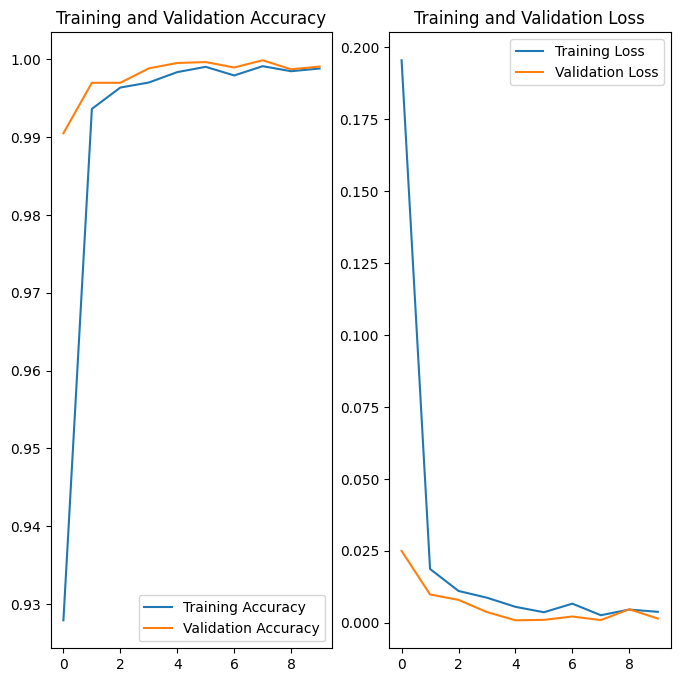

In [11]:
# get accuracy and loss for training and validation from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss'] # training loss
val_loss = history.history['val_loss'] # validation loss

# define the range of epochs
epochs_range = range(epochs)

# set up the plotting area
plt.figure(figsize=(8, 8))

# plot training and validation accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plot training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Performance Evaluation and Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2024-11-10 23:04:40.237267: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


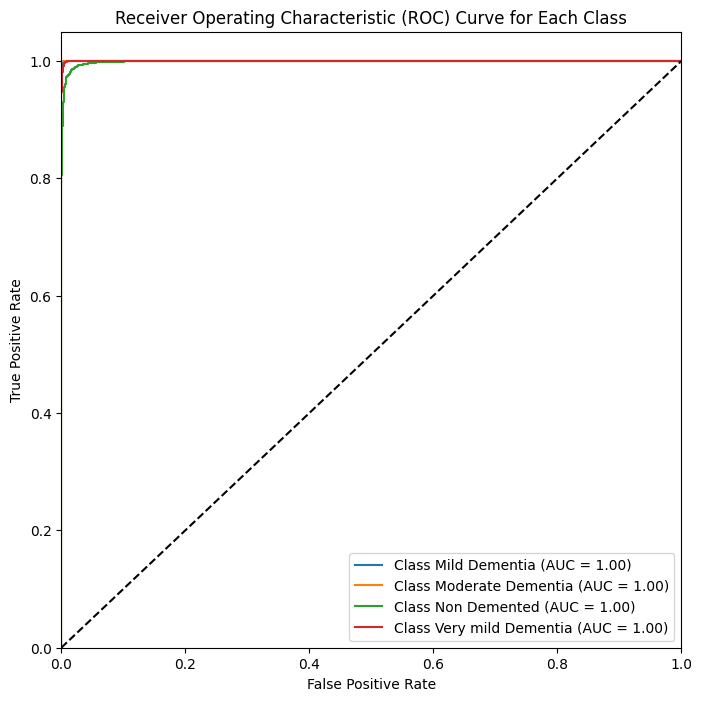

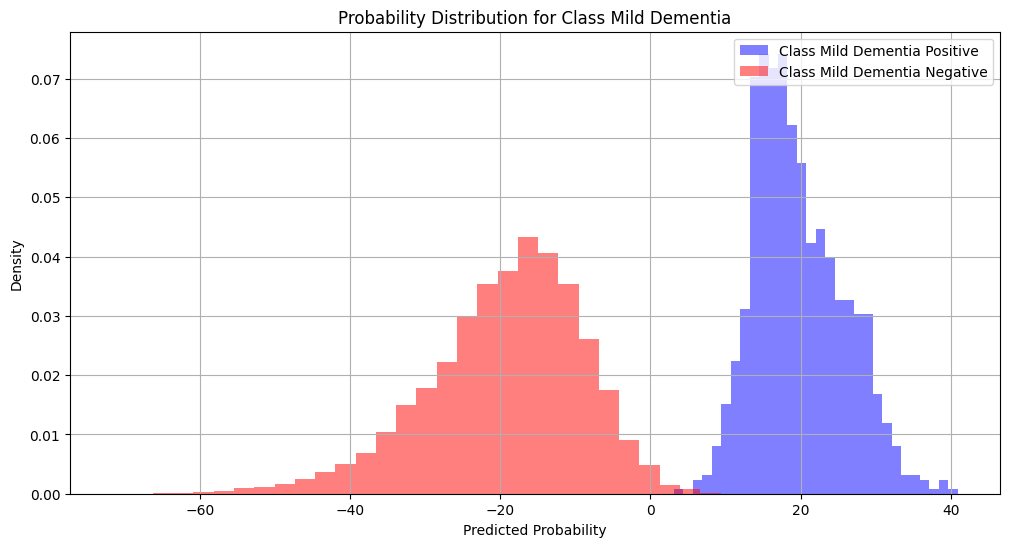

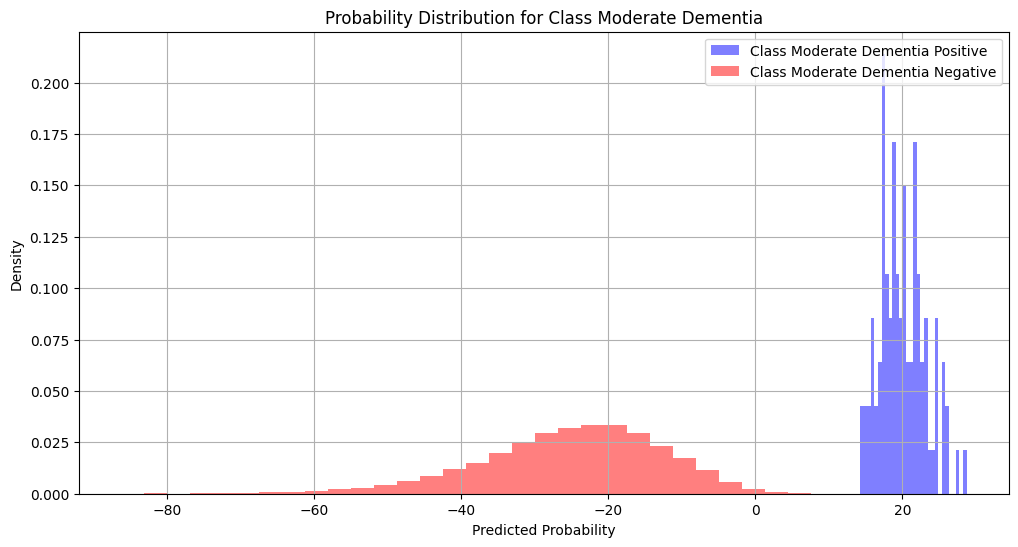

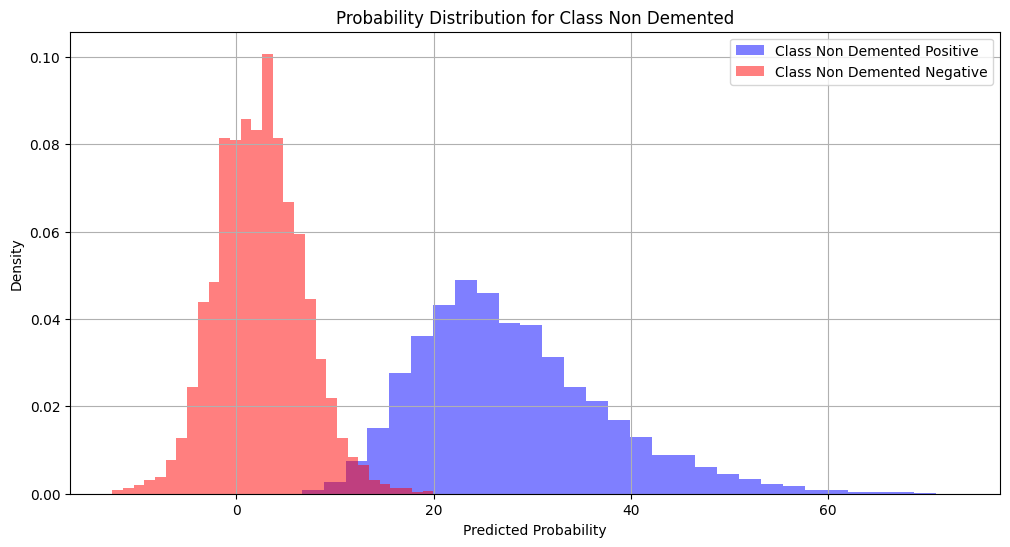

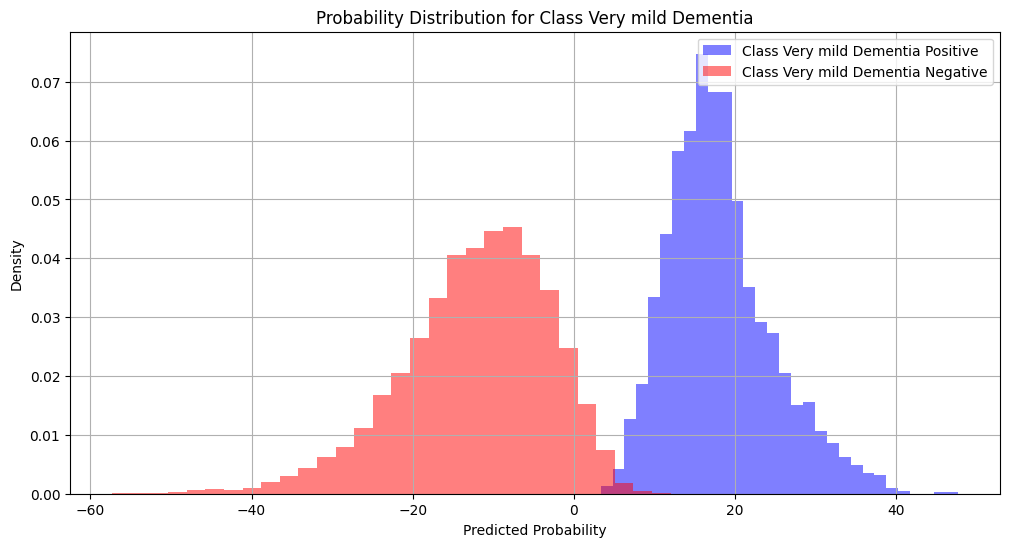

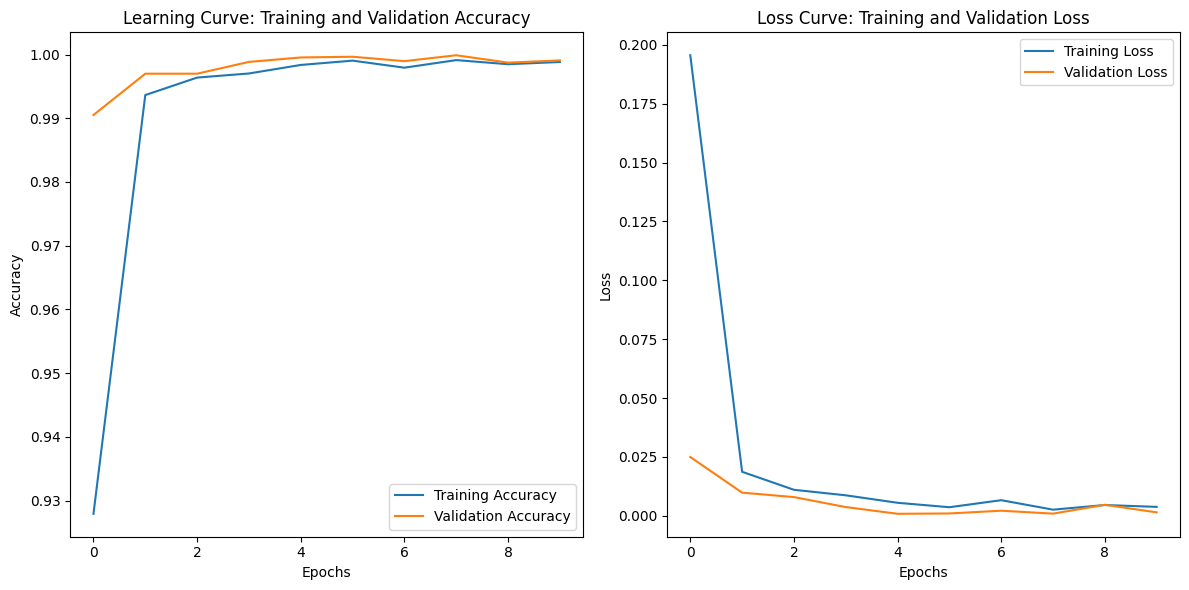

In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# initialize lists to collect true and predicted labels, and predicted probabilities
true_labels = []
predicted_labels = []
predicted_probabilities_all = []

# iterate over test dataset to collect true labels, predicted labels, and predicted probabilities 
for images, labels in test_ds:
    true_labels.extend(labels.numpy())
    predicted_probabilities = model.predict(images)
    predicted_labels.extend(np.argmax(predicted_probabilities, axis=1))
    predicted_probabilities_all.extend(predicted_probabilities)

# convert lists to numpy arrays for easier manipulation
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
predicted_probabilities_all = np.array(predicted_probabilities_all)

# calculate and print evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

# prepare ROC and AUC for each class
num_classes = len(classes)
true_labels_bin = label_binarize(true_labels, classes=range(num_classes))

fpr = dict() # false positive
tpr = dict() # true positive
roc_auc = dict() # auc

# compute ROC and AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_probabilities_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot ROC
plt.figure(figsize=(8, 8))
c = {0: "Mild Dementia", 1: "Moderate Dementia", 2: "Non Demented", 3: "Very mild Dementia"}
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {c[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--') # diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

# plot probability distributions for eachc lass
for i in range(num_classes):
    plt.figure(figsize=(12, 6))
    # plot histogram for positive class probabilities
    plt.hist(predicted_probabilities_all[true_labels == i][:, i], bins=30, alpha=0.5, 
             label=f'Class {c[i]} Positive', color='blue', density=True)
    # plot histogram for negative class probabilities
    plt.hist(predicted_probabilities_all[true_labels != i][:, i], bins=30, alpha=0.5, 
             label=f'Class {c[i]} Negative', color='red', density=True)
    plt.title(f'Probability Distribution for Class {c[i]}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

# learning curves for accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(12, 6))

# learning curve -- accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Training and Validation Accuracy')

# loss curve -- loss over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve: Training and Validation Loss')

plt.tight_layout()
plt.show()